In [114]:
import os
from pathlib import Path
import IPython.display as ipd
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from IPython import display
import time
from datetime import datetime, timedelta
import tensorflow as tf
import seaborn as sns
import subprocess
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

# NOTES
NOTES = "28x28"

# VARS
target_label = "Label"
id_label = "fname"
OUTSTR = "A{:.4f}_Type{}_UDR{}_THRESH{:5.3f}_DROP{}_LR{}_S{}_B{}{}.csv"
IMG_EXT = ".png"
VERBOSE = True
DISPLAY = True
TEST = False
MFCC = False
TPU = False
RESIZE = True
INPUT_WIDTH = 128
INPUT_HEIGHT = 128
TARGET_WIDTH = 28 if RESIZE else INPUT_WIDTH
TARGET_HEIGHT = 28 if RESIZE else INPUT_HEIGHT
DECAY_RATE = 0.9
IMG_CHANNELS = 3
DROPOUT = 0.4
TYPE = "CNN"
DEFAULT_BS = 128 # default batch size
UNK_DROP_RATE = 1.0 # drop 100% of unknown categories

CATEGORY = ["no_voice"]
LABELS = ["lights on", "turn off"]
CHANNELS = [1,2,3,5,6,7,8]
NUMS = ''.join([str(x) for x in CHANNELS])
MONTHS = [9]
DAYS = [25]

if TEST:
    LEARNING_STEPS = 100
    SPP = 4
    LEARNING_RATE = .05
    BATCH_SIZE = 32
    VERBOSITY = 1000
    TEST_SIZE = 1000
    SHUFFLE_SIZE = 64
else:
    LEARNING_STEPS = 5000
    SPP = 200
    LEARNING_RATE = .025
    BATCH_SIZE = 64
    VERBOSITY = 1000
    SHUFFLE_SIZE = 256

def curr_time():
    return datetime.now() - timedelta(hours=7) # offset from UTC to PST

ROOT = os.getcwd() + "/"
if CATEGORY[0] == "no_voice":
    RUN_ROOT = ROOT+"NONVOCAL_RUNS_YN_{:02}_{:02}/".format(MONTHS[0], DAYS[0])
else:
    RUN_ROOT = ROOT+"VOCAL_RUNS_YN_{:02}_{:02}/".format(MONTHS[0], DAYS[0])
RUN_ROOT_LOG = RUN_ROOT+"logs/"

# PATHS
paths = {
    "Training":ROOT+"09_25_juan.csv",
    "Model":RUN_ROOT+"model_dir_{}/".format(NUMS),
    "Logs":RUN_ROOT_LOG+"{}_{}/".format(NUMS, datetime.strftime(curr_time(), "%b%d%Y_%H%M%S"))
}
paths["Log"] = paths["Logs"] + "log.txt"
if not os.path.isdir(RUN_ROOT):
    os.mkdir(RUN_ROOT)
if not os.path.isdir(RUN_ROOT_LOG):
    os.mkdir(RUN_ROOT_LOG)
if not os.path.isdir(paths["Logs"]):
    os.mkdir(paths["Logs"])

In [115]:
def make_header(s):
    return ("#" * 42) + ("\n{:^42}\n".format(s)) + ("#" * 42)
    
def print_and_log(s):
    with open(paths["Log"], 'a') as log:
        log.write(str(s))
        log.write("\n")
    print(s)
        
def print_and_log_header(s):
    h = make_header(str(s))
    with open(paths["Log"], 'a') as log:
        log.write(h)
        log.write("\n")
    print(h)

In [116]:
def sec_to_str(secs):
    ms = secs - int(secs)
    days = int(secs // (24 * 3600))
    hours = int((secs % ((24 * 3600))) // 3600)
    minutes = int((secs % 3600) // 60)
    seconds = int(secs % 60)
    return "{:02}:{:02}:{:02}:{:02}.{}".format(days, hours, minutes, seconds, "{:.3}".format(ms)[2:])

def timer(f, *args):
    print_and_log("Start: {}".format(curr_time()))
    start = time.time()
    result = f(*args)
    end = time.time()
    print_and_log("End: {}".format(curr_time()))
    print_and_log("Finished in {}".format(sec_to_str(end - start)))
    return result

def preprocess(samples, sample_rate):
    padded = np.zeros(sample_rate)
    samples = samples[:sample_rate]
    padded[:samples.shape[0]] = samples
    return padded

def select_labels(df, allowed):
    return df[df['Label'].isin(allowed)]
    
def select_categories(df, allowed):
    return df[df['Category'].isin(allowed)]

def select_channels(df, allowed):
    labels = []
    for i in range(1, 9):
        if i not in allowed:
            labels.append("Path{}".format(i))
    return df.drop(labels, axis=1)

def select_days(df, allowed):
    return df[df['Day'].isin(allowed)]

def select_months(df, allowed):
    return df[df['Month'].isin(allowed)]

def select_sets(df, allowed):
    return df[df['Set'].isin(allowed)]

def remove_voice(df):
    return df.drop(["Path4"], axis=1)

def str_to_l(x):
    return [int(n) for n in x if n <= '9' and n >= '0']

In [117]:
count = 0
def _parse_function(label, *filenames):
    global count
    count += 1
    if count % VERBOSITY == 0:
        print_and_log("\tProcessed {}th image".format(count))
    expected_shape = tf.constant([1, INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS])
    image = None
    for filename in filenames:
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_image(image_string, channels=IMG_CHANNELS)
        image_decoded = tf.image.convert_image_dtype(image_decoded, tf.float32)
        image_decoded = tf.reshape(image_decoded, expected_shape)
        image_decoded = tf.image.rgb_to_grayscale(image_decoded)
        if RESIZE:
            image_decoded = tf.image.resize_bicubic(image_decoded, [TARGET_HEIGHT, TARGET_WIDTH])
        if image is not None:
            image = tf.concat([image, image_decoded], 3)
        else:
            image = image_decoded
    return image, label

In [118]:
def model_fn(features, labels, mode):
    input_layer = tf.reshape(features, [-1, TARGET_HEIGHT, TARGET_WIDTH, len(CHANNELS)])
    pool = input_layer

    for num_filters in [32, 64]:
        conv = tf.layers.conv2d(
            inputs=pool,
            filters=num_filters,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool = tf.layers.flatten(pool)
    dense = tf.layers.dense(inputs=pool, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=DROPOUT, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=num_labels)
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if not TPU:
        tf.summary.histogram("predictions", predictions["probabilities"])
        tf.summary.histogram("classes", predictions["classes"])

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    learning_rate = tf.train.exponential_decay(LEARNING_RATE, tf.train.get_global_step(), SPP, DECAY_RATE, staircase=True)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        if TPU:
            optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [119]:
def create_training_input_fn(dataset, batch_size, num_epochs=None):
    def _input_fn(num_epochs=None, shuffle=True):
        ds = dataset.batch(batch_size).repeat(num_epochs)
        if shuffle:
            ds = ds.shuffle(SHUFFLE_SIZE)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def create_predict_input_fn(dataset, batch_size):
    def _input_fn():
        ds = dataset.batch(batch_size)
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    return _input_fn

def train_helper(steps_per_period):
    classifier.train(
        input_fn=train_input_fn,
        steps=steps_per_period)
    training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
    validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
    t_ll = training_stats["loss"]
    t_acc = 100 * training_stats["accuracy"]
    v_ll = validation_stats["loss"]
    v_acc = 100 * validation_stats["accuracy"]
    return classifier, t_ll, v_ll, t_acc, v_acc

def train():
    periods = LEARNING_STEPS // SPP
    steps_per_period = LEARNING_STEPS // periods
    t_accs, v_accs = [], []
    t_lls, v_lls = [], []
    print_and_log("Training model...\nMetrics:")
    print_and_log("\tPERIOD\tRATE\tTYPE\tTRAIN.\tVALID.\tTIME")
    for period in range(periods):
        lr = LEARNING_RATE * (DECAY_RATE ** ((period * SPP) / SPP))
        classifier, t_ll, v_ll, t_acc, v_acc = train_helper(steps_per_period)
        print_and_log("\t{}\t{:.5f}\tLgLs\t{:.2f}\t{:.2f}\t{}".format(period, lr, t_ll, v_ll, curr_time()))
        print_and_log("\t\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
        t_lls.append(t_ll)
        v_lls.append(v_ll)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
    v_accuracy = v_accs[-1]
    return classifier, v_accuracy, t_lls, v_lls, t_accs, v_accs

In [120]:
with open(paths["Log"], 'w') as log:
    log.write(make_header("Starting Script\n"))

In [121]:
# Create variables for the paths
train_csv = paths["Training"]

# Store the labels to train
all_labels = LABELS
labels = ["lights on", "turn off"]
num_labels = len(labels)# - 1
labels = {x[1]:x[0] for x in enumerate(labels)}
reverse_lookup = {labels[k]:k for k in labels}

In [122]:
# Make the training data
print_and_log_header("MAKING TRAINING DATA")
train_data = pd.read_csv(train_csv)

# Filter the training data
train_data = select_categories(train_data, CATEGORY)
train_data = select_channels(train_data, CHANNELS)
train_data = select_labels(train_data, all_labels)
train_data = select_months(train_data, MONTHS)
train_data = select_days(train_data, DAYS)
# train_data = remove_voice(train_data)

train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data["Label"] = train_data["Label"].map(labels)

if VERBOSE:
    print_and_log_header("TRAIN DATA")
    print_and_log(train_data.describe())
    print_and_log(train_data.head(10))

##########################################
           MAKING TRAINING DATA           
##########################################
##########################################
                TRAIN DATA                
##########################################
          Day   Month        Label  SequenceNumber  Path9  Path10  Path11  \
count  1812.0  1812.0  1812.000000     1812.000000    0.0     0.0     0.0   
mean     25.0     9.0     0.500000      452.500000    NaN     NaN     NaN   
std       0.0     0.0     0.500138      261.611711    NaN     NaN     NaN   
min      25.0     9.0     0.000000        0.000000    NaN     NaN     NaN   
25%      25.0     9.0     0.000000      226.000000    NaN     NaN     NaN   
50%      25.0     9.0     0.500000      452.500000    NaN     NaN     NaN   
75%      25.0     9.0     1.000000      679.000000    NaN     NaN     NaN   
max      25.0     9.0     1.000000      905.000000    NaN     NaN     NaN   

       Path12  Path13  Path14  Path15  Path16  P

In [123]:
# Grab subset of the data for testing purposes
if TEST:
    train_data = train_data[:TEST_SIZE]

In [124]:
# 80/10/10 training/validation/test split
validation_data = select_sets(train_data, ["Validation"])
test_data = select_sets(train_data, ["Testing"])
train_data = select_sets(train_data, ["Training"])

In [125]:
ids = test_data["Path{}".format(CHANNELS[0])] # store the png filenames for output
if VERBOSE:
    print_and_log_header("IDS")
    print_and_log(ids.describe())
    print_and_log(ids.head(10))

##########################################
                   IDS                    
##########################################
count                                                   180
unique                                                  180
top       /Users/42robotics/Desktop/cerebro_voice_demo/i...
freq                                                      1
Name: Path1, dtype: object
23    /Users/42robotics/Desktop/cerebro_voice_demo/i...
29    /Users/42robotics/Desktop/cerebro_voice_demo/i...
31    /Users/42robotics/Desktop/cerebro_voice_demo/i...
50    /Users/42robotics/Desktop/cerebro_voice_demo/i...
62    /Users/42robotics/Desktop/cerebro_voice_demo/i...
65    /Users/42robotics/Desktop/cerebro_voice_demo/i...
68    /Users/42robotics/Desktop/cerebro_voice_demo/i...
70    /Users/42robotics/Desktop/cerebro_voice_demo/i...
72    /Users/42robotics/Desktop/cerebro_voice_demo/i...
74    /Users/42robotics/Desktop/cerebro_voice_demo/i...
Name: Path1, dtype: object


In [126]:
# Separate Labels
train_labels = train_data.pop(target_label)
validation_labels = validation_data.pop(target_label)
test_labels = test_data.pop(target_label)
img_paths = ["Path{}".format(channel) for channel in CHANNELS]
train_data = train_data[img_paths]
validation_data = validation_data[img_paths]
test_data = test_data[img_paths]

In [127]:
# Vectors of filenames.
t_f, v_f, s_f = [], [], []
for i in range(1, 1 + len(CHANNELS)):
    channel = CHANNELS[i-1]
    l = "Path{}".format(channel)
    t_f.append(tf.constant(train_data[l]))
    v_f.append(tf.constant(validation_data[l]))
    s_f.append(tf.constant(test_data[l]))

# `labels[i]` is the label for the image in `filenames[i]
# Vectors of labels
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)
test_labels = tf.constant(test_labels)

# Make datasets from filenames and labels
train_data = tf.data.Dataset.from_tensor_slices((train_labels, *t_f))
validation_data = tf.data.Dataset.from_tensor_slices((validation_labels, *v_f))
test_data = tf.data.Dataset.from_tensor_slices((test_labels, *s_f))
print_and_log_header("Parsing Training Data")
train_data = timer(lambda: train_data.map(_parse_function))
print_and_log_header("Parsing Validation Data")
validation_data = timer(lambda: validation_data.map(_parse_function))
print_and_log_header("Parsing Testing Data")
test_data = timer(lambda: test_data.map(_parse_function))
print_and_log("\nDone!")

##########################################
          Parsing Training Data           
##########################################
Start: 2018-09-25 10:20:17.137365
End: 2018-09-25 10:20:17.570403
Finished in 00:00:00:00.432
##########################################
         Parsing Validation Data          
##########################################
Start: 2018-09-25 10:20:17.572222
End: 2018-09-25 10:20:18.344946
Finished in 00:00:00:00.772
##########################################
           Parsing Testing Data           
##########################################
Start: 2018-09-25 10:20:18.346860
End: 2018-09-25 10:20:18.725357
Finished in 00:00:00:00.378

Done!


In [128]:
print_and_log_header("TRAINING")
print_and_log(train_data)
print_and_log(type(train_data))
print_and_log_header("VALIDATION")
print_and_log(validation_data)
print_and_log(type(validation_data))
print_and_log_header("TESTING")
print_and_log(test_data)
print_and_log(type(test_data))

##########################################
                 TRAINING                 
##########################################
<MapDataset shapes: ((1, 28, 28, 7), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                VALIDATION                
##########################################
<MapDataset shapes: ((1, 28, 28, 7), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
##########################################
                 TESTING                  
##########################################
<MapDataset shapes: ((1, 28, 28, 7), ()), types: (tf.float32, tf.int64)>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [129]:
# Create the Estimator
if TPU:
    classifier = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        model_dir=paths["Model"],
        config=tf.contrib.tpu.RunConfig(),
        use_tpu=TPU)
else:
    classifier = tf.estimator.Estimator(model_fn=model_fn, model_dir=paths["Model"])

In [130]:
# Create the input functions.
training_eval_input_fn = create_predict_input_fn(train_data, DEFAULT_BS)
validation_eval_input_fn = create_predict_input_fn(validation_data, DEFAULT_BS)
test_eval_input_fn = create_predict_input_fn(test_data, DEFAULT_BS)
train_input_fn = create_training_input_fn(train_data, BATCH_SIZE)

In [131]:
# Train
classifier, accuracy, t_lls, v_lls, t_accs, v_accs = timer(train)

Start: 2018-09-25 10:20:19.023603
Training model...
Metrics:
	PERIOD	RATE	TYPE	TRAIN.	VALID.	TIME
	0	0.02500	LgLs	0.58	0.59	2018-09-25 10:22:24.319606
			Acc.	75.28%	75.00%

	1	0.02250	LgLs	0.51	0.52	2018-09-25 10:23:44.507050
			Acc.	80.79%	81.11%

	2	0.02025	LgLs	0.45	0.46	2018-09-25 10:25:04.312076
			Acc.	83.20%	80.56%

	3	0.01823	LgLs	0.41	0.42	2018-09-25 10:26:21.591625
			Acc.	83.75%	81.11%

	4	0.01640	LgLs	0.38	0.40	2018-09-25 10:27:32.231793
			Acc.	84.99%	81.11%

	5	0.01476	LgLs	0.35	0.37	2018-09-25 10:28:43.137619
			Acc.	86.57%	83.89%

	6	0.01329	LgLs	0.36	0.39	2018-09-25 10:29:54.013489
			Acc.	85.95%	87.78%

	7	0.01196	LgLs	0.32	0.35	2018-09-25 10:31:11.814809
			Acc.	87.81%	85.00%

	8	0.01076	LgLs	0.31	0.33	2018-09-25 10:32:28.272727
			Acc.	88.15%	86.67%

	9	0.00969	LgLs	0.30	0.33	2018-09-25 10:33:44.591858
			Acc.	89.53%	86.67%

	10	0.00872	LgLs	0.29	0.33	2018-09-25 10:35:07.181353
			Acc.	88.84%	88.33%

	11	0.00785	LgLs	0.28	0.31	2018-09-25 11:16:21.051540
			Acc.	88.

Final accuracy (on validation data): 88.8889%


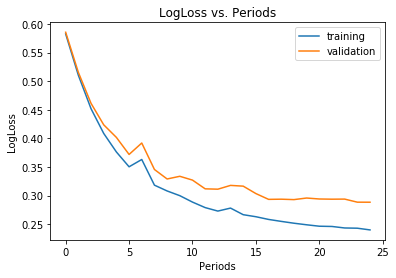

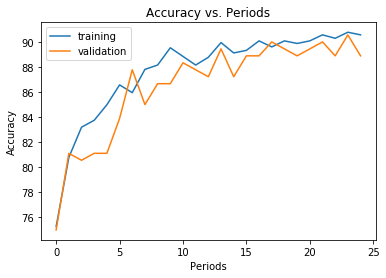

<Figure size 432x288 with 0 Axes>

In [132]:
print_and_log("Final accuracy (on validation data): {:.4f}%".format(accuracy))

if DISPLAY:
    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(t_lls, label="training")
    plt.plot(v_lls, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "loss.png")

    # Output a graph of accuracy over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(t_accs, label="training")
    plt.plot(v_accs, label="validation")
    plt.legend()
    plt.show()
    plt.savefig(paths["Logs"] + "accuracy.png")

In [133]:
test_stats = classifier.evaluate(input_fn=test_eval_input_fn)
t_ll = test_stats["loss"]
t_acc = 100 * test_stats["accuracy"]
print_and_log_header("TESTING")
print_and_log("\tLog Loss: {:.2f}".format(t_ll))
print_and_log("\tAccuracy: {:.2f}%".format(t_acc))

##########################################
                 TESTING                  
##########################################
	Log Loss: 0.38
	Accuracy: 87.22%
